In [1]:
import pysam
import time

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from collections import defaultdict, Counter
from operator import itemgetter
from itertools import groupby

sns.set(style='whitegrid', font='serif')

# Часть 1: анализ ридов Illumina

In [2]:
def plot_genome_coverage(sam_file, step=1000):
    sam = pysam.AlignmentFile(sam_file, "r")
    reference_length = sam.get_reference_length(sam.references[0])

    starts = [(read.reference_start, 'start') for read in sam if not read.is_unmapped]
    sam = pysam.AlignmentFile(sam_file, "r")
    ends = [(read.reference_end, 'end') for read in sam if not read.is_unmapped]
    checkpoints = [(i, 'check') for i in range(step, reference_length, step)]

    all_events = sorted(starts + ends + checkpoints)

    curr_coverage = 0
    coverages = []
    for pos, event_type in all_events:
        if event_type == 'start':
            curr_coverage += 1
        elif event_type == 'end':
            curr_coverage -= 1
        else:
            coverages.append(curr_coverage)
    
    print('Mean genome coverage:', np.mean(coverages))
    print('% of covered genome:', sum(map(lambda c: c > 0, coverages)) / len(coverages) * 100)
    sns.scatterplot(range(len(coverages)), coverages)
    plt.xticks([], [])
    plt.show()

def plot_insert_size_distribution(sam_file, max_percentile_plot=99.9):
    sam = pysam.AlignmentFile(sam_file, "r")
    insert_sizes = [abs(read.template_length) for read in sam if not read.mate_is_unmapped]

    print('Mean insert size:', np.mean(insert_sizes))
    print('Standard deviation:', np.std(insert_sizes))
    print('Interval with 95% of reads:', np.percentile(insert_sizes, 2.5), '-', np.percentile(insert_sizes, 97.5))

    insert_sizes = np.array(insert_sizes)
    plt.hist(insert_sizes[insert_sizes <= np.percentile(insert_sizes, max_percentile_plot)], bins=80)
    plt.xlabel('Insert size')
    plt.ylabel('Count')
    plt.show()
    
    
def _print_table_from_dict(snps, values, skip_diagonal=True):
    print(' ' * 18, (' ' * 16).join(map(lambda c: str(c).ljust(2), values)))
    for i, n1 in enumerate(values):
        print(f'{n1}'.ljust(2), end='')
        for n2 in values:
            print(f'{snps[n1, n2] if n1 != n2 or not skip_diagonal else "-"}'.rjust(18), end='')
        print()

def _update_snps_with_read(snps, ref_seq, read_seq):
    for ref_n, read_n in zip(ref_seq, read_seq):
        if ref_n != read_n:
            snps[(ref_n.upper(), read_n)] += 1
    
def print_snps_stats_illumina(sam_file):
    sam = pysam.AlignmentFile(sam_file, "r")

    snps = Counter()
    all_bases_count = 0
    for i, read in enumerate(sam):
        if read.is_unmapped or read.is_supplementary: continue
        reference_sequence = read.get_reference_sequence()
        read_sequence = read.query_alignment_sequence

        _update_snps_with_read(snps, reference_sequence, read_sequence)
        all_bases_count += len(reference_sequence)
   
    _print_table_from_dict(snps, values=['A', 'C', 'G', 'T'])    
    print('Error rate:', sum(snps.values()) / all_bases_count * 100, '%')

## Датасет №1: E.coli/100x.1.fastq.gz, E.coli/100x.2.fastq.gz 

In [68]:
!bwa index data/2a/MG1655-K12.fasta

!bwa mem data/2a/MG1655-K12.fasta data/2a/100x.1.fastq.gz data/2a/100x.2.fastq.gz > data/2a/100x_alignment.sam


[bwa_index] Pack FASTA... 0.04 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 1.63 seconds elapse.
[bwa_index] Update BWT... 0.04 sec
[bwa_index] Pack forward-only FASTA... 0.03 sec
[bwa_index] Construct SA from BWT and Occ... 0.59 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index data/2a/MG1655-K12.fasta
[main] Real time: 2.362 sec; CPU: 2.351 sec
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 100000 sequences (10000000 bp)...
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 48198, 0, 1)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (207, 214, 222)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (177, 252)
[M::mem_pestat] mean and std.dev: (214.45, 10.19)
[M::mem_pestat] low and high boundaries for proper pairs: (162

[M::mem_process_seqs] Processed 100000 reads in 5.571 CPU sec, 5.457 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 48165, 0, 0)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (207, 214, 222)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (177, 252)
[M::mem_pestat] mean and std.dev: (214.44, 10.16)
[M::mem_pestat] low and high boundaries for proper pairs: (162, 267)
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 100000 reads in 5.977 CPU sec, 5.876 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 48104, 0, 0)
[M::mem_pestat] skip orientation FF as there are n

[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (1, 48134, 0, 0)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (207, 214, 222)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (177, 252)
[M::mem_pestat] mean and std.dev: (214.39, 10.17)
[M::mem_pestat] low and high boundaries for proper pairs: (162, 267)
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 100000 reads in 6.330 CPU sec, 6.321 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 48151, 0, 0)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orienta

[M::mem_process_seqs] Processed 100000 reads in 4.894 CPU sec, 4.601 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (1, 48162, 0, 0)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (207, 214, 222)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (177, 252)
[M::mem_pestat] mean and std.dev: (214.37, 10.21)
[M::mem_pestat] low and high boundaries for proper pairs: (162, 267)
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 100000 reads in 4.971 CPU sec, 4.701 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 48220, 0, 0)
[M::mem_pestat] skip orientation FF as there are n

[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (1, 48149, 0, 0)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (207, 214, 222)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (177, 252)
[M::mem_pestat] mean and std.dev: (214.43, 10.16)
[M::mem_pestat] low and high boundaries for proper pairs: (162, 267)
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 100000 reads in 6.257 CPU sec, 6.356 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 48142, 0, 0)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orienta

In [76]:
!samtools flagstat data/2a/100x_alignment.sam

5000581 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
581 + 0 supplementary
0 + 0 duplicates
4991553 + 0 mapped (99.82% : N/A)
5000000 + 0 paired in sequencing
2500000 + 0 read1
2500000 + 0 read2
4978334 + 0 properly paired (99.57% : N/A)
4983734 + 0 with itself and mate mapped
7238 + 0 singletons (0.14% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


## 1. Покрытие генома.


Mean genome coverage: 105.1265358913559
% of covered genome: 100.0


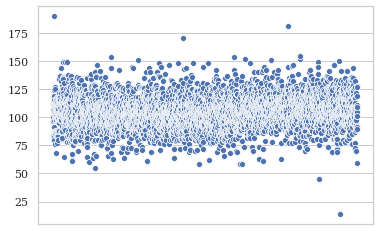

In [3]:
plot_genome_coverage('data/2a/100x_alignment.sam')

## 2. Распределение расстояния вставки.


Mean insert size: 958.2865998390881
Standard deviation: 44726.710528634634
Interval with 95% of reads: 196.0 - 235.0


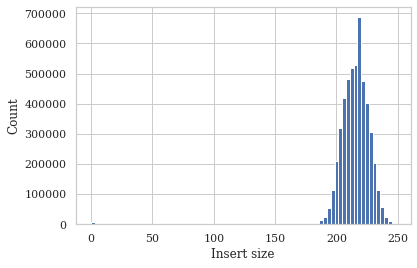

In [4]:
plot_insert_size_distribution('data/2a/100x_alignment.sam')    

## 3. Частоты различных замен

In [5]:
print_snps_stats_illumina('data/2a/100x_alignment.sam')

                   A                 C                 G                 T 
A                  -            668350            405900            167899
C             300579                 -            280707            182186
G             184198            279377                 -            301647
T             171080            403968            663336                 -
Error rate: 0.8910150953320577 %


## Датасет №2: ecoli_mda_lane1_left.downsampled.fastq.gz, ecoli_mda_lane1_right.downsampled.fastq.gz

In [7]:
!bwa mem data/2a/MG1655-K12.fasta data/2a/ecoli_mda_lane1_left.downsampled.fastq.gz data/2a/ecoli_mda_lane1_right.downsampled.fastq.gz > data/2a/mda_lane1_alignment.sam

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 100000 sequences (10000000 bp)...
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (112, 44880, 44, 139)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (890, 2400, 4678)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 12254)
[M::mem_pestat] mean and std.dev: (3073.67, 2476.43)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 16042)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (249, 279, 299)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (149, 399)
[M::mem_pestat] mean and std.dev: (277.18, 39.54)
[M::mem_pestat] low and high boundaries for proper pairs: (99, 449)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50

[M::mem_process_seqs] Processed 100000 reads in 4.953 CPU sec, 4.646 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (120, 45065, 37, 130)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (1121, 2446, 5713)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 14897)
[M::mem_pestat] mean and std.dev: (3451.37, 2748.10)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 19489)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (252, 280, 300)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (156, 396)
[M::mem_pestat] mean and std.dev: (279.36, 36.53)
[M::mem_pestat] low and high boundaries for proper pairs: (108, 444)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (

[M::mem_process_seqs] Processed 100000 reads in 5.638 CPU sec, 5.336 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (145, 45005, 36, 145)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (1085, 2696, 5079)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 13067)
[M::mem_pestat] mean and std.dev: (3306.94, 2619.11)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 17061)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (255, 280, 300)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (165, 390)
[M::mem_pestat] mean and std.dev: (281.63, 33.54)
[M::mem_pestat] low and high boundaries for proper pairs: (120, 435)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (

[M::mem_process_seqs] Processed 100000 reads in 5.467 CPU sec, 5.160 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (106, 45171, 47, 151)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (1166, 2844, 5356)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 13736)
[M::mem_pestat] mean and std.dev: (3508.18, 2735.13)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 17926)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (255, 280, 300)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (165, 390)
[M::mem_pestat] mean and std.dev: (281.74, 33.46)
[M::mem_pestat] low and high boundaries for proper pairs: (120, 435)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (

[M::mem_process_seqs] Processed 100000 reads in 5.153 CPU sec, 4.857 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (130, 44672, 48, 138)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (882, 2483, 5545)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 14871)
[M::mem_pestat] mean and std.dev: (3287.26, 2720.82)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 19534)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (256, 281, 300)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (168, 388)
[M::mem_pestat] mean and std.dev: (282.32, 32.78)
[M::mem_pestat] low and high boundaries for proper pairs: (124, 432)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (2

[M::mem_process_seqs] Processed 100000 reads in 5.155 CPU sec, 4.849 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (124, 44827, 48, 138)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (1443, 2989, 5470)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 13524)
[M::mem_pestat] mean and std.dev: (3720.62, 2739.13)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 17551)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (257, 281, 301)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (169, 389)
[M::mem_pestat] mean and std.dev: (282.81, 32.07)
[M::mem_pestat] low and high boundaries for proper pairs: (125, 433)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (

[M::mem_process_seqs] Processed 100000 reads in 6.397 CPU sec, 7.871 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (140, 43430, 44, 133)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (1465, 3313, 5407)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 13291)
[M::mem_pestat] mean and std.dev: (3581.09, 2540.76)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 17233)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (237, 279, 299)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (113, 423)
[M::mem_pestat] mean and std.dev: (265.69, 54.37)
[M::mem_pestat] low and high boundaries for proper pairs: (48, 485)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (2

[M::mem_process_seqs] Processed 100000 reads in 5.434 CPU sec, 5.211 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (125, 44867, 40, 138)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (1382, 2942, 5658)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 14210)
[M::mem_pestat] mean and std.dev: (3549.59, 2723.99)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 18486)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (254, 280, 300)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (162, 392)
[M::mem_pestat] mean and std.dev: (280.55, 35.09)
[M::mem_pestat] low and high boundaries for proper pairs: (116, 438)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (

[M::mem_process_seqs] Processed 100000 reads in 7.120 CPU sec, 8.002 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (142, 45011, 46, 122)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (1312, 2806, 4943)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 12205)
[M::mem_pestat] mean and std.dev: (3323.96, 2500.05)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 15836)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (254, 280, 300)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (162, 392)
[M::mem_pestat] mean and std.dev: (280.72, 34.72)
[M::mem_pestat] low and high boundaries for proper pairs: (116, 438)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (

[M::mem_process_seqs] Processed 100000 reads in 4.860 CPU sec, 4.553 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (111, 45009, 37, 137)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (1320, 3107, 5881)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 15003)
[M::mem_pestat] mean and std.dev: (3840.86, 2853.29)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 19564)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (254, 280, 300)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (162, 392)
[M::mem_pestat] mean and std.dev: (280.63, 34.88)
[M::mem_pestat] low and high boundaries for proper pairs: (116, 438)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (

[M::mem_process_seqs] Processed 100000 reads in 7.675 CPU sec, 7.739 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (121, 44644, 32, 152)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (1202, 2372, 5393)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 13775)
[M::mem_pestat] mean and std.dev: (3489.26, 2846.81)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 17966)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (250, 279, 300)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (150, 400)
[M::mem_pestat] mean and std.dev: (277.66, 39.05)
[M::mem_pestat] low and high boundaries for proper pairs: (100, 450)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (

[M::mem_process_seqs] Processed 100000 reads in 5.014 CPU sec, 4.734 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (129, 45132, 48, 133)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (1215, 2842, 6161)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 16053)
[M::mem_pestat] mean and std.dev: (3624.22, 2761.49)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 20999)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (250, 280, 300)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (150, 400)
[M::mem_pestat] mean and std.dev: (277.67, 39.15)
[M::mem_pestat] low and high boundaries for proper pairs: (100, 450)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (

## 1. Покрытие генома.

Mean genome coverage: 119.24380254365165
% of covered genome: 96.3138607458504


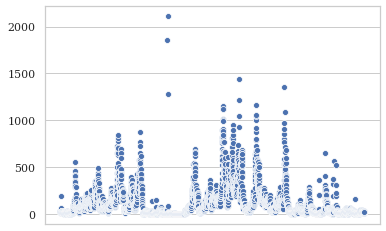

In [6]:
plot_genome_coverage('data/2a/mda_lane1_alignment.sam')

## 2. Распределение расстояния вставки.

Mean insert size: 32206.697906362744
Standard deviation: 249641.80781840318
Interval with 95% of reads: 86.0 - 31869.849999999627


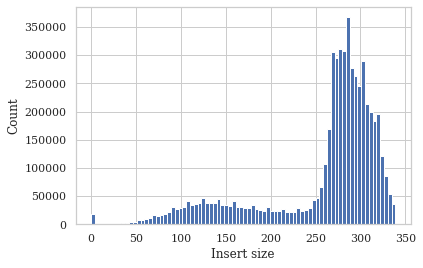

In [7]:
plot_insert_size_distribution('data/2a/mda_lane1_alignment.sam', max_percentile_plot=96)    

## 3. Частоты различных замен

In [8]:
print_snps_stats_illumina('data/2a/mda_lane1_alignment.sam')

                   A                 C                 G                 T 
A                  -            658432            413164            207930
C             322356                 -            268770            210948
G             210785            270483                 -            318740
T             213000            416655            641694                 -
Error rate: 0.8974580175450242 %


# Часть 2: анализ ридов IonTorrent

## 1. Статистика ридов IonTorrent

In [9]:
def print_ion_torrent_stats(sam_file):
    sam = pysam.AlignmentFile(sam_file, "r")

    snps = Counter()
    all_bases_count = 0
    indel_lengths = []
    all_change_qualities, all_insert_qualities = [], []
    homopolymers_change = Counter()
    min_homopolymer_length, max_homopolymer_length = 2, 7

    def make_string_from_iterable_with_nones(it):
        return ''.join(map(lambda c: c if c else '_', it))

    def _change_insert_quality_with_read(ref_seq, read_seq, read_quality):
        change_qualities, insert_qualities = [], []

        for ref_n, read_n, read_q in zip(ref_seq, read_seq, read_quality):
            if ref_n != read_n and read_n != '_':
                if ref_n == '_': insert_qualities.append(read_q)
                else: change_qualities.append(read_q)

        return change_qualities, insert_qualities

    def _count_homopolimers(cnt, ref_seq, read_seq):
        i_end = 0
        curr_start_index = 0
        curr_n = '?'
        ref_base_count = 0

        for n, g in groupby(ref_seq + '$'):
            ref_len = len(list(g))
            i_start = i_end
            i_end += ref_len

            if i_start == 0:
                curr_n = n
                ref_base_count = ref_len
                continue

            if n == curr_n or n == '_':
                if n == curr_n:
                    ref_base_count += ref_len
            else:
                if min_homopolymer_length <= ref_base_count <= max_homopolymer_length:
                    read_base_count = read_seq[curr_start_index:i_start].count(curr_n)
                    cnt[(ref_base_count, read_base_count)] += 1

                curr_n = n
                ref_base_count = ref_len
                curr_start_index = i_start

    for i, read in enumerate(sam):
        if read.is_unmapped or read.is_supplementary: continue

        # getting usable matched sequences
        pairs = read.get_aligned_pairs(matches_only=False, with_seq=True)
        full_ref_seq = make_string_from_iterable_with_nones(map(itemgetter(2), pairs))

        read_seq = read.query_sequence
        full_read_seq = make_string_from_iterable_with_nones(read_seq[i] if i else None for i in map(itemgetter(0), pairs))

        read_quality = read.query_qualities
        full_read_quality = [i if i else None for i in map(itemgetter(0), pairs)]

        assert len(full_ref_seq) == len(full_read_seq) == len(full_read_quality)

        # Frequency of replacement / insertion / deletion table
        _update_snps_with_read(snps, full_ref_seq, full_read_seq)

        # All bases count
        all_bases_count += len(pairs)

        # change_qualities, insert_qualities distribution
        change_qualities, insert_qualities = _change_insert_quality_with_read(full_ref_seq, full_read_seq, full_read_quality)
        all_change_qualities += change_qualities
        all_insert_qualities += insert_qualities

        # indel length distribution
        indel_lengths += [len(list(g)) for n, g in groupby(full_read_seq) if n == '_']

        # homopolimers
        _count_homopolimers(homopolymers_change, full_ref_seq, full_read_seq)

    print('Indel length distribution:')
    indels_counter = Counter(indel_lengths)
    for k in sorted(indels_counter.keys()):
        print(f'    length={k}, count={indels_counter[k]}')
    print()

    _print_table_from_dict(snps, values=['A', 'C', 'G', 'T', '_'])

    print()
    print('Error rate (including indels and duplications):', sum(snps.values()) / all_bases_count * 100, '%')

    plt.hist(all_change_qualities, alpha=0.5, bins=30, density=True, label='Change')
    plt.hist(all_insert_qualities, alpha=0.5, bins=30, density=True, label='Insert')
    plt.legend()
    plt.xlabel('Quality')
    plt.ylabel('Normed count (sum = 1)')
    plt.title('Quality distribution')
    plt.show()

    print('Homopolimers changes')
    _print_table_from_dict(homopolymers_change, values=range(min_homopolymer_length, max_homopolymer_length + 1), skip_diagonal=False)


## Датасет №1: B22-730.fastq.gz

In [ ]:
!bwa index data/2b/DH10B-K12.fasta

In [6]:
!bwa mem data/2b/DH10B-K12.fasta data/2b/B22-730.fastq.gz > data/2b/B22_alignment.sam

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 30580 sequences (10000589 bp)...
[M::process] read 30700 sequences (10000499 bp)...
[M::mem_process_seqs] Processed 30580 reads in 6.342 CPU sec, 7.610 real sec
[M::process] read 30654 sequences (10000464 bp)...
[M::mem_process_seqs] Processed 30700 reads in 7.919 CPU sec, 10.025 real sec
[M::process] read 30558 sequences (10000069 bp)...
[M::mem_process_seqs] Processed 30654 reads in 7.624 CPU sec, 7.626 real sec
[M::process] read 30468 sequences (10000148 bp)...
[M::mem_process_seqs] Processed 30558 reads in 6.471 CPU sec, 7.519 real sec
[M::process] read 30596 sequences (10000413 bp)...
[M::mem_process_seqs] Processed 30468 reads in 6.577 CPU sec, 8.797 real sec
[M::process] read 30514 sequences (10000381 bp)...
[M::mem_process_seqs] Processed 30596 reads in 7.742 CPU sec, 14.328 real sec
[M::process] read 30520 sequences (10000266 bp)...
[M::mem_process_seqs] Processed 30514 reads in 6.228 CPU sec, 6.967 real sec
[M::

In [7]:
!samtools flagstat data/2b/B22_alignment.sam

497384 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
2463 + 0 supplementary
0 + 0 duplicates
489459 + 0 mapped (98.41% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


### Покрытие генома

Mean genome coverage: 34.180324370465215
% of covered genome: 100.0


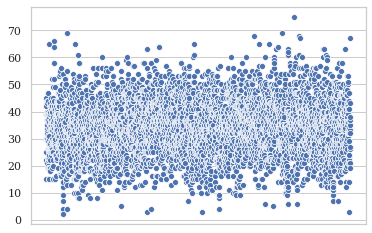

In [10]:
plot_genome_coverage('data/2b/B22_alignment.sam')

### Статистики ридов IonTorrent

Indel length distribution:
    length=1, count=826313
    length=2, count=18828
    length=3, count=1402
    length=4, count=277
    length=5, count=76
    length=6, count=23
    length=7, count=10
    length=8, count=3
    length=14, count=1
    length=16, count=1
    length=24, count=1

                   A                 C                 G                 T                 _ 
A                  -              8633             22825             10074            235177
C               9793                 -              7445             15789            174576
G              16386              6778                 -              9316            189612
T              10658             23900              8523                 -            226286
_             578812            431111            429747            579712                 -

Error rate (including indels and duplications): 1.8577708233779169 %


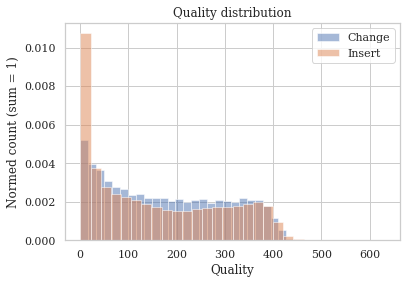

Homopolimers changes
                   2                 3                 4                 5                 6                 7 
2           22921356              7008              1608              1144               641               476
3              98587           5517927              4082               852               502               325
4                352             62815           1435754              2152               448               233
5                 10               325             38592            451482               891               233
6                  1                19               412             21562            126331               326
7                  0                 1                32               360              9705             24507


In [11]:
print_ion_torrent_stats('data/2b/B22_alignment.sam')

## Датасет №2: C24-698.fastq.gz

In [12]:
!bwa mem data/2b/DH10B-K12.fasta data/2b/C24-698.fastq.gz > data/2b/C24_alignment.sam

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 40748 sequences (10000257 bp)...
[M::process] read 40830 sequences (10000256 bp)...
[M::mem_process_seqs] Processed 40748 reads in 4.668 CPU sec, 4.747 real sec
[M::process] read 40678 sequences (10000475 bp)...
[M::mem_process_seqs] Processed 40830 reads in 4.409 CPU sec, 4.290 real sec
[M::process] read 40934 sequences (10000123 bp)...
[M::mem_process_seqs] Processed 40678 reads in 4.914 CPU sec, 4.723 real sec
[M::process] read 40668 sequences (10000353 bp)...
[M::mem_process_seqs] Processed 40934 reads in 3.656 CPU sec, 3.484 real sec
[M::process] read 40714 sequences (10000220 bp)...
[M::mem_process_seqs] Processed 40668 reads in 3.563 CPU sec, 3.377 real sec
[M::process] read 40714 sequences (10000207 bp)...
[M::mem_process_seqs] Processed 40714 reads in 4.123 CPU sec, 3.968 real sec
[M::process] read 40584 sequences (10000468 bp)...
[M::mem_process_seqs] Processed 40714 reads in 4.774 CPU sec, 4.813 real sec
[M::pr

In [13]:
!samtools flagstat data/2b/C24_alignment.sam

686667 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
1261 + 0 supplementary
0 + 0 duplicates
682638 + 0 mapped (99.41% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


Indel length distribution:
    length=1, count=896620
    length=2, count=10228
    length=3, count=881
    length=4, count=115
    length=5, count=31
    length=6, count=5
    length=7, count=1
    length=8, count=3
    length=10, count=1

                   A                 C                 G                 T                 _ 
A                  -              4833             21414              6039            204118
C               6351                 -              4759             13560            238742
G              13116              4635                 -              6295            257556
T               6177             22061              4793                 -            196629
_             214059            174927            173676            214969                 -

Error rate (including indels and duplications): 1.0647378106006624 %


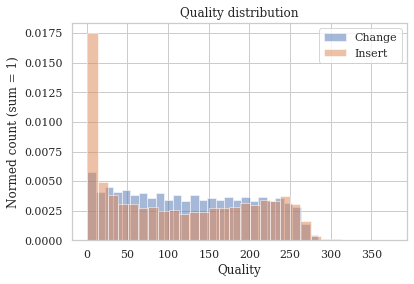

Homopolimers changes
                   2                 3                 4                 5                 6                 7 
2           24161933              3386               935               524               313               226
3              97908           5765639              1307               329               197               110
4                258             31344           1513474               514               141                74
5                  4               130             13590            485611               278                73
6                  0                 5               111              7328            142812               115
7                  0                 0                 2                67              3544             31569


In [14]:
print_ion_torrent_stats('data/2b/C24_alignment.sam')

## 2. Повторить любые два пункта из задания 1 с помощью другого выравнивателя, сравнить результаты

In [15]:
!bowtie2-build data/2b/DH10B-K12.fasta data/2b/DH10B-K12.bt2

Settings:
  Output files: "data/2b/DH10B-K12.bt2.*.bt2"
  Line rate: 6 (line is 64 bytes)
  Lines per side: 1 (side is 64 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Max bucket size: default
  Max bucket size, sqrt multiplier: default
  Max bucket size, len divisor: 4
  Difference-cover sample period: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  data/2b/DH10B-K12.fasta
Building a SMALL index
Reading reference sizes
  Time reading reference sizes: 00:00:00
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences
  Time to join reference sequences: 00:00:01
bmax according to bmaxDivN setting: 1171534
Using parameters --bmax 878651 --dcv 1024
  Doing ahead-of-time memory usage test
  Passed!  Constructing with these parameters: --bmax 878651 --dcv 1024
Construc

  60%
  70%
  80%
  90%
  100%
  Block accumulator loop time: 00:00:01
  Sorting block of length 783065
  (Using difference cover)
  Sorting block time: 00:00:00
Returning block of 783066
Getting block 2 of 7
  Reserving size (878651) for bucket
  Calculating Z arrays
  Calculating Z arrays time: 00:00:00
  Entering block accumulator loop:
  10%
  20%
  30%
  40%
  50%
  60%
  70%
  80%
  90%
  100%
  Block accumulator loop time: 00:00:00
  Sorting block of length 708346
  (Using difference cover)
  Sorting block time: 00:00:00
Returning block of 708347
Getting block 3 of 7
  Reserving size (878651) for bucket
  Calculating Z arrays
  Calculating Z arrays time: 00:00:00
  Entering block accumulator loop:
  10%
  20%
  30%
  40%
  50%
  60%
  70%
  80%
  90%
  100%
  Block accumulator loop time: 00:00:00
  Sorting block of length 729530
  (Using difference cover)
  Sorting block time: 00:00:01
Returning block of 729531
Getting block 4 of 7
  Reserving size (878651) for bucket
  Calculat

In [16]:
!bowtie2 -x data/2b/DH10B-K12.bt2 -U data/2b/B22-730.fastq.gz -S data/2b/B22_alignment_way2.sam

494921 reads; of these:
  494921 (100.00%) were unpaired; of these:
    10992 (2.22%) aligned 0 times
    448286 (90.58%) aligned exactly 1 time
    35643 (7.20%) aligned >1 times
97.78% overall alignment rate


In [17]:
!samtools flagstat data/2b/B22_alignment_way2.sam

494921 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
483929 + 0 mapped (97.78% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


Indel length distribution:
    length=1, count=822055
    length=2, count=19927
    length=3, count=1638
    length=4, count=250
    length=5, count=67
    length=6, count=13
    length=7, count=2
    length=8, count=4
    length=11, count=1
    length=24, count=1

                   A                 C                 G                 T                 _ 
A                  -             34158             48029             39249            244835
C              40279                 -             34320             44098            186428
G              45091             33656                 -             40190            201035
T              40266             49105             33587                 -            236019
_             201054             93275             92490            202711                 -

Error rate (including indels and duplications): 1.2138593879802155 %


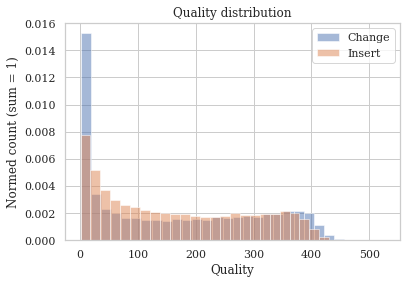

Homopolimers changes
                   2                 3                 4                 5                 6                 7 
2           22873242              6142               292                65                17                10
3              98442           5506713              3140               158                42                 8
4                361             62070           1433348              1591               116                15
5                  5               344             37924            451220               521                73
6                  2                22               419             21144            126461               155
7                  0                 1                32               380              9560             24599


In [18]:
print_ion_torrent_stats('data/2b/B22_alignment_way2.sam')

Средняя частота ошибок bowtie2 оказалась меньше. 
При этом количество замен нуклеотидов выросоло в 2-4 раза, количество вставок уменьшилось в 3-5 раз, а количество инделов осталось примерно тем же. Кажется, что поэтому статистика инделов и осталась примерно такой же.

Распределения для качества ридов и гомополиморфных замен выглядит похоже. В первом случае немного выше качество при заменах, во втором при вставках. Количество гомополиморфных замен в обоих случаях преобладает в меньшую сторону (e.g. вместо 5 bp прочитали 4 bp).